In [75]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from collections import Counter
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp
import itertools

from st_utils import correct_tissue_names, correct_platform_panel
from st_utils import get_processed
from st_utils import get_qced_cell_id
from constants import matching_cores_2024 as matching_cores
from constants import SAMPLES,sample_color, CB_COLORS_5

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

agbt_color = 'eff8f3'
fig_size = (8,8)

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')

year = '2024'

samples = [x for x in SAMPLES]
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)

working directory: /Users/whuan/dev/ist_benchmarking
['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']


# Cell count: gather data

In [76]:

CORE_RADIUS_DICT = {'xenium_breast_htma':300,
                    'xenium_breast_normal':650,
                    'xenium_panhuman_normal':650,
                    'xenium_panhuman_htma':300,
                    'xenium_lung_htma':300,
                    'xenium_lung_normal':650,
                    'merscope_breast_htma':300,
                    'merscope_breast_normal':650,
                    'merscope_lung_normal':650,
                    'merscope_lung_htma':300,
                    'cosmx_multitissue_htma':300,
                    'cosmx_multitissue_normal':650,
                    
                    '2024_xenium_breast_htma':350,
                    '2024_xenium_breast_tumor2':560,
                    '2024_merscope_breast_htma':350,
                    '2024_merscope_breast_tumor2':560,
                    '2024_cosmx_multitissue_htma':650,
                    '2024_cosmx_multitissue_tumor2':650,
                    }


ids, dic = get_qced_cell_id(10,0)
df_c_all = pd.DataFrame()

for filtration in ['Before', 'After']:
    for sample in samples:
        df_cells = pd.read_parquet(
            f'{wd}/data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'
            )
        
        df_cells = df_cells[['core','tissue_type','cell_id']]
        df_cells = correct_tissue_names(sample,df_cells)
        df_cells.core = df_cells.core.astype('int')
        df_cells['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df_cells.core = df_cells.core.astype('str')
        df_cells = df_cells.loc[~df_cells['tissue_type'].isin(['Marker','MARKER'])]
        df_cells = df_cells.drop_duplicates()
        if filtration == 'After':
            df_cells = df_cells.loc[df_cells['cell_id'].isin(ids)]
        df_metric = df_cells.groupby(by = ['core','tissue_type']).agg({'cell_id':'count'})
        df_metric = df_metric.rename({'cell_id':'cell_count'}, axis=1)
        df_metric['Sample'] = sample
        df_metric['TMA'] = sample.split('_')[-1].upper()
        df_metric['Platform_Panel'] = df_metric['Sample'].apply(lambda x: f"{x.split('_')[-3].upper()}_{x.split('_')[-2].capitalize()}")
        df_metric = correct_platform_panel(df_metric, 'Platform_Panel')
        df_metric['Filtration'] = filtration

        df_c_all = pd.concat([df_c_all, df_metric])

df_c_all = df_c_all.reset_index()
matching_cores = [str(x) for x in matching_cores]
df_c_all = df_c_all.loc[df_c_all['core'].isin(matching_cores)]


In [77]:
cos_fovs = pd.DataFrame()
for sample in samples:
    if 'cosmx' in sample:
        df = get_processed(sample, 'cell_level')
        df.core = df.core.astype('int')
        df['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
        df.core = df.core.astype('str')
        df_s = df[['core','fov']].drop_duplicates().sort_values(by=['core'])
        d = pd.DataFrame.from_dict(dict(Counter(df_s['core'])), orient='index', columns=['cos_fov_count'])
        d.reset_index(inplace=True)
        d.rename(columns={'index': 'core'}, inplace=True)
        cos_fovs = pd.concat([cos_fovs, d], ignore_index=True)

df_c_all = pd.merge(df_c_all, cos_fovs, on='core', how='left')
df_c_all.head()

,core,tissue_type,cell_count,Sample,TMA,Platform_Panel,Filtration,cos_fov_count
0,100,BrC,2304,2024_xenium_breast_htma,HTMA,"Xenium,Breast",Before,1
1,101,BrC,1550,2024_xenium_breast_htma,HTMA,"Xenium,Breast",Before,1
2,103,BrC,775,2024_xenium_breast_htma,HTMA,"Xenium,Breast",Before,1
3,104,BrC,2726,2024_xenium_breast_htma,HTMA,"Xenium,Breast",Before,1
4,105,BrC,2310,2024_xenium_breast_htma,HTMA,"Xenium,Breast",Before,1


In [78]:
fov_area = 4256**2 * 0.12**2

metric = 'cell_count'
unit = 'µm^2'
count_of_unit = 1000
plot_metric = f'{metric}_per_{count_of_unit}{unit}'
df_c_all = df_c_all.sort_values(by=['Sample'])
df_c_all[f'area_{unit}'] = df_c_all.apply(lambda row: fov_area * row['cos_fov_count'] if 'cosmx' in row['Sample'] else 3.14 * CORE_RADIUS_DICT[row['Sample']]**2 , axis=1)
df_c_all[f'{metric}_per_{count_of_unit}{unit}'] = df_c_all[metric] * count_of_unit / df_c_all[f'area_{unit}']

metric = 'cell_count_per_1000µm^2'

df_c_all = df_c_all.rename(columns={"tissue_type":"Tissue Type"})
# df_c_all['cell_count_per_1000um^2'] = df_c_all['cell_count_per_1000um^2'].apply(lambda x: round(x,1))
grouped_df = df_c_all[['Tissue Type', 'Sample', metric]].groupby(['Tissue Type', 'Sample']).median().reset_index()
pivoted_df = grouped_df.pivot_table(index='Tissue Type', columns='Sample', values=metric)
pivoted_df.reset_index(inplace=False)

pivoted_df.to_csv(f'{wd}/tables/cell_count.csv')


groupby='Sample'
df_metric = df_c_all.groupby(by = ['TMA',groupby]).agg({metric:'median'})
df_metric = df_metric.sort_values(by=['TMA',metric], ascending=False)
df_metric = df_metric.round(1)
df_metric.to_csv(f'{wd}/tables/cell_per_area_by_sample.csv', index=True)

df_metric

cell_count_per_1000µm^2
TMA    Sample                                                
TUMOR2 2024_xenium_breast_tumor2                          5.2
       2024_cosmx_multitissue_tumor2                      4.8
       2024_merscope_breast_tumor2                        1.0
HTMA   2024_cosmx_multitissue_htma                        5.8
       2024_xenium_breast_htma                            5.3
       2024_merscope_breast_htma                          2.5

In [79]:
groupby='Platform'

df_metric = df_c_all.copy()
df_metric['Platform'] = df_metric['Sample'].apply(lambda x: x.split("_")[-3].upper())
df_metric = df_metric.groupby(by = ['TMA',groupby]).agg({metric:'median'})
df_metric = df_metric.sort_values(by=['TMA',metric], ascending=False)
df_metric = df_metric.round(1)
df_metric.to_csv(f'{wd}/tables/cell_per_area_by_platform_by_tma.csv', index=True)
display(df_metric)


df_metric = df_c_all.copy()
df_metric['Platform'] = df_metric['Sample'].apply(lambda x: x.split("_")[-3].upper())
df_metric = df_metric.groupby(by = [groupby]).agg({metric:'median'})
df_metric = df_metric.sort_values(by=[metric], ascending=False)
df_metric = df_metric.round(1)
df_metric.to_csv(f'{wd}/tables/cell_per_area_by_platform.csv', index=True)
display(df_metric)

cell_count_per_1000µm^2
TMA    Platform                         
TUMOR2 XENIUM                        5.2
       COSMX                         4.8
       MERSCOPE                      1.0
HTMA   COSMX                         5.8
       XENIUM                        5.3
       MERSCOPE                      2.5

,cell_count_per_1000µm^2
Platform,
COSMX,5.3
XENIUM,5.3
MERSCOPE,1.9


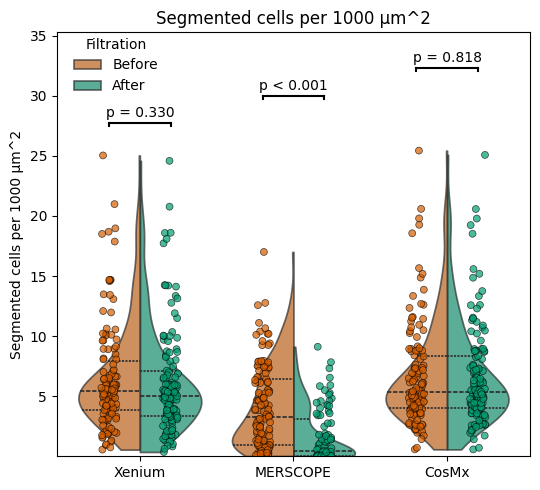

In [80]:

df_all = df_c_all.copy()
df_all['platform'] = df_all['Platform_Panel'].apply(lambda x: x.split(',')[0])

metrics = ['cell_count_per_1000µm^2']

# One color per platform, plus "Before"/"After" for the split halves
palette = {
    'Xenium':   CB_COLORS_5['blue_dark'],
    'MERSCOPE': CB_COLORS_5['red'],
    'CosMx':    CB_COLORS_5['green'],
    'Before':   CB_COLORS_5['red'],
    'After':    CB_COLORS_5['green']
}

fig, ax = plt.subplots(figsize=(5.5, 5))

for metric in metrics:
    subset = df_all.copy()
    platform_order = ['Xenium', 'MERSCOPE', 'CosMx']

    # Violin plot (split by Filtration)
    violin = sns.violinplot(
        x='platform',
        y=metric,
        data=subset,
        hue='Filtration',
        split=True,
        palette=palette,
        order=platform_order,
        cut=0,
        scale='width',
        inner='quart',
        alpha=0.7,
        ax=ax
    )

    # Strip plot (show individual data points)
    strip = sns.stripplot(
        x='platform',
        y=metric,
        data=subset,
        hue='Filtration',
        palette=palette,
        order=platform_order,
        dodge=True,            # separate points by Filtration
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        ax=ax
    )

    # Remove duplicate legend on the axes
    ax.legend_.remove()

    ax.set_title(f"Segmented cells per {count_of_unit} {unit}")
    ax.set_xlabel("")
    ax.set_ylabel(f"Segmented cells per {count_of_unit} {unit}")

    # Dictionary mapping platform -> x-position
    x_positions = {p: idx for idx, p in enumerate(platform_order)}
    y_max = subset[metric].max()
    y_min = subset[metric].min()
    
    # We'll keep track of how far to shift each bracket vertically
    bracket_step = 0.09 * (y_max - y_min) if (y_max - y_min) != 0 else 0.08
    bracket_count = 0

    # ----------------------------------------------------------------------
    # ONLY: Stats *within* each platform (Before vs. After)
    # ----------------------------------------------------------------------
    for p in platform_order:
        data_before = subset.loc[
            (subset['platform'] == p) & (subset['Filtration'] == 'Before'),
            metric
        ]
        data_after = subset.loc[
            (subset['platform'] == p) & (subset['Filtration'] == 'After'),
            metric
        ]
        # If either group is empty, skip
        if data_before.empty or data_after.empty:
            continue
        
        # Mann-Whitney test for Before vs After within this platform
        bracket_count += 1
        bracket_y = y_max + bracket_count * bracket_step

        x_center = x_positions[p]
        # We'll assume ~0.2 offset from x_center for half-violin
        x_left = x_center - 0.2
        x_right = x_center + 0.2

        stat, pval = sp.mannwhitneyu(data_before, data_after, alternative='two-sided')

        # Horizontal bracket (from x_left to x_right)
        ax.plot([x_left, x_right], [bracket_y, bracket_y], lw=1.5, color='black')
        # Vertical ticks
        tick_height = 0.01 * (y_max - y_min)
        ax.plot([x_left, x_left], [bracket_y, bracket_y - tick_height], lw=1.5, color='black')
        ax.plot([x_right, x_right], [bracket_y, bracket_y - tick_height], lw=1.5, color='black')

        # Format the p-value text
        if pval < 0.001:
            p_text = "p < 0.001"
        else:
            p_text = f"p = {pval:.3f}"

        ax.text(
            0.5*(x_left + x_right),
            bracket_y + tick_height,
            p_text,
            ha='center', va='bottom',
            fontsize=10, color='black'
        )

    # Expand y-limits to ensure all brackets are visible
    ax.set_ylim(y_min, y_max + (bracket_count + 1.3) * bracket_step)

# Create a single legend (handles/labels from the violin plot),
# slicing to keep only "Before" and "After" if there's something else in the list.
handles, labels = violin.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]

fig.legend(
    handles,
    labels,
    title="Filtration",
    loc='upper left',
    bbox_to_anchor=(0.12, 0.94),
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


## plot with plotly (depreciated)

In [81]:

# fontsize = 40
# width = 1100
# height = 750

# groupby = 'Platform_Panel'


# # df = df_c_all.loc[df_c_all['Sample'].str.contains('2024', na=False)]
# # df['Platform'] = df['Platform_Panel'].apply(lambda x: x.split(",")[0])
# df = df_c_all.copy()

# fig = go.Figure()

# fig.add_trace(go.Violin(x=df[groupby][df['Filtration'] == 'Before'],
#                         y=df[f'{plot_metric}'][df['Filtration'] == 'Before'],
#                         legendgroup='Yes', scalegroup='Yes', name='Before',
#                         side='negative',
#                         line_color='red',
#                         showlegend=True)
#              )
# fig.add_trace(go.Violin(x=df[groupby][df['Filtration'] == 'After'],
#                         y=df[f'{plot_metric}'][df['Filtration'] == 'After'],
#                         legendgroup='No', scalegroup='No', name='After',
#                         side='positive',
#                         line_color='green',
#                         showlegend=True)
#              )
# fig.update_traces(meanline_visible=True)
# fig.update_yaxes(title_text=f"Segmented cells per {count_of_unit} {unit}",
#                 title_font=dict(size=fontsize), range=[-5,30], tickfont=dict(size=fontsize-2), showline=True, linewidth=2, linecolor='black')
# fig.update_xaxes(title_text="", tickfont=dict(size=fontsize-2), showline=True, linewidth=2, linecolor='black')




# fig.update_layout(
#     violingap=0.35,  # Set the gap between violins
#     violinmode='overlay',  # Overlay mode for violins
#     width=width,  # Set the width of the figure
#     height=height,  # Set the height of the figure
#     legend=dict(
#         orientation="h",  # horizontal alignment
#         yanchor="bottom", 
#         y=0.8,  # position legend just above the plot
#         xanchor="right",
#         x=0.70  # center the legend
#     ),
#     font=dict(color='black', size=fontsize),
#     paper_bgcolor='rgba(0,0,0,0)',
#     plot_bgcolor='rgba(0,0,0,0)',
# )

# fig.show()
# pio.write_image(fig, f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_count.png', scale=4, width=width, height=height)
# pio.write_image(fig, f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_count.eps', scale=4, width=width, height=height)
# pio.write_image(fig, f'figures/Fig_4_Segmentation/Main_Fig_4_B_cell_count.svg', scale=4, width=width, height=height)
